In [1]:
%matplotlib inline

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from yellowbrick.features.base import FeatureVisualizer
from yellowbrick.exceptions import YellowbrickTypeError
from yellowbrick.style.colors import resolve_colors, get_color_cycle
from yellowbrick.bestfit import draw_best_fit

class JointPlotVisualizer(FeatureVisualizer):
    def __init__(self, ax=None, estimator='linear', feature=None, target=None, 
                 joint_plot='scatter', joint_args=None, 
                 xy_plot='hist', xy_args=None,
                 size=6, ratio=5, space=.2, **kwargs):
        super(JointPlotVisualizer, self).__init__(ax, **kwargs)
        
        self.feature = feature
        self.target = target
        self.joint_plot = joint_plot
        self.joint_args = joint_args
        self.xy_plot = xy_plot
        self.xy_args = xy_args
        
        fig = plt.figure(figsize=(size, size))
        gs = plt.GridSpec(ratio + 1, ratio + 1)
        
        #while ax is a part of FeatureVisualizer, it will be defined within the class
        #since there are 3 axes objects
        joint_ax = fig.add_subplot(gs[1:, :-1])
        x_ax = fig.add_subplot(gs[0, :-1], sharex=joint_ax)
        y_ax = fig.add_subplot(gs[1:, -1], sharey=joint_ax)
        
        fig.tight_layout()
        fig.subplots_adjust(hspace=space, wspace=space)
        
        self.fig = fig
        self.joint_ax = joint_ax
        self.x_ax = x_ax
        self.y_ax = y_ax
        
    
        plt.setp(self.x_ax.get_xticklabels(), visible=False)
        plt.setp(self.y_ax.get_yticklabels(), visible=False)

        plt.setp(self.x_ax.yaxis.get_majorticklines(), visible=False)
        plt.setp(self.x_ax.yaxis.get_minorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_majorticklines(), visible=False)
        plt.setp(self.y_ax.xaxis.get_minorticklines(), visible=False)
        plt.setp(self.x_ax.get_yticklabels(), visible=False)
        plt.setp(self.y_ax.get_xticklabels(), visible=False)
        self.x_ax.yaxis.grid(False)
        self.y_ax.xaxis.grid(False)
    
    def fit(self, X, y, **kwargs):
        #TODO: throw an error if y is null
        #TODO: throw an error if X has more than one column
        # Draw the instances
        # Get the shape of the data

        # Handle the feature names if they're None.
        if self.feature is None:

            # If X is a data frame, get the columns off it.
            if is_dataframe(X):
                self.feature = X.columns
            
            else:
                self.feature = ['x']

        # Handle the feature names if they're None.
        if self.target is None:
            self.target = ['y']
            
        self.draw(X, y, **kwargs)
        return self
    
    
    def draw(self, X, y, **kwargs):     
        self.draw_joint(X, y, **kwargs)
        self.draw_xy(X, y, **kwargs)
              
    def draw_joint(self, X, y, **kwargs):
        if self.joint_args is None:
            self.joint_args = {}
        
        if self.joint_plot == "scatter":
            self.joint_args.setdefault("alpha", 0.4)
            aspect = self.joint_args.pop("aspect", "auto")
            self.joint_ax.set_aspect(aspect)
            self.joint_ax.scatter(X, y, **self.joint_args)
        
            fit = self.joint_args.pop("fit", True)
            if fit:
                estimator = self.joint_args.pop("estimator", "linear")
                draw_best_fit(X, y, self.joint_ax, estimator)
                
        elif self.joint_plot == "hex":
            x_bins = self.joint_args.pop("x_bins", 50)
            y_bins = self.joint_args.pop("y_bins", 50)
            self.joint_args.setdefault("alpha", 0.4)
            colormap = self.joint_args.pop("cmap", 'Blues')
            gridsize = int(np.mean([x_bins, y_bins]))
            
            xmin = X.min()
            xmax = X.max()
            ymin = y.min()
            ymax = y.max()
            
            #plt.cm.RdBu
            self.joint_ax.hexbin(X, y, gridsize=gridsize, cmap=colormap, **self.joint_args)
            self.joint_ax.axis([xmin, xmax, ymin, ymax])

    def draw_xy(self, X, y, **kwargs):
        if self.xy_args is None:
            self.xy_args = {}
        
        if self.xy_plot == "hist":
            hist_bins = self.xy_args.pop("bins", 50)
            self.xy_args.setdefault("alpha", 0.4)
            self.x_ax.hist(X, bins=hist_bins, **self.xy_args)
            self.y_ax.hist(y, bins=hist_bins, orientation='horizontal', **self.xy_args)
              
    def poof(self, **kwargs):
        self.joint_ax.set_xlabel(self.feature)
        self.joint_ax.set_ylabel(self.target)
        self.finalize(**kwargs)
        
    def finalize(self, **kwargs):
        """
        Finalize executes any subclass-specific axes finalization steps.
        The user calls poof and poof calls finalize.

        Parameters
        ----------
        kwargs: generic keyword arguments.

        """
        #self.joint_ax.set_title("Joint Plot of {} vs {}"
        #             .format(self.feature, self.target))  

In [4]:
import os
import sys  
import pandas as pd

## The path to the test data sets
FIXTURES  = os.path.join(os.getcwd(), "data")

## Dataset loading mechanisms
datasets = {
    "credit": os.path.join(FIXTURES, "credit", "credit.csv"),
    "concrete": os.path.join(FIXTURES, "concrete", "concrete.csv"),
    "occupancy": os.path.join(FIXTURES, "occupancy", "occupancy.csv"),
}


def load_data(name):
    """
    Loads and wrangles the passed in dataset by name.
    If download is specified, this method will download any missing files. 
    """
    
    # Get the path from the datasets 
    path = datasets[name]
        
    # Return the data frame
    return pd.read_csv(path)

In [5]:
# Load the data
df = load_data('concrete')
features = ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
feature = 'cement'
target = 'strength'
# Get the X and y data from the DataFrame 
X = df[feature].as_matrix()
y = df[target].as_matrix()

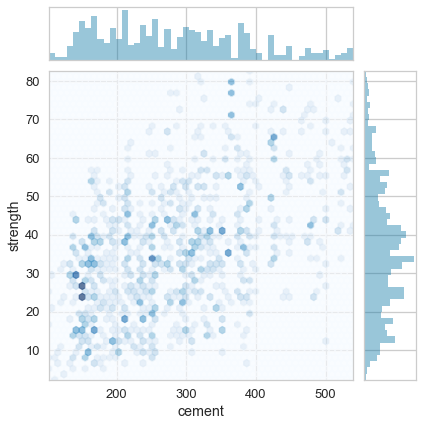

In [18]:
visualizer = JointPlotVisualizer(feature=feature, target=target, joint_plot="hex")
visualizer.fit(X, y)                # Fit the data to the visualizer
visualizer.draw_joint(X, y)
g = visualizer.poof()    # Draw/show/poof the data